In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import os
import sys
sys.path.append('./scripts/')

import warnings
warnings.filterwarnings('ignore')

import gzip
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats import mannwhitneyu

import oncotree
from mutrate import KEYS, set_mutrate
from datasets_build import reformat, format_data
from plot import plot_auc_volcano, comparison_boxplot

conf.config_params()

tree = oncotree.Oncotree()
leaves = tree.get_ttypes('CANCER')

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

KeyError: 'PATH_SOURCE_DATA'

# Extended Figure 7a

In [ ]:
# Load data

fn = os.path.join(conf.output_boostdm, 'model_selection', 'eval_data.pickle.gz')
with gzip.open(fn, 'rb') as f:
    model_dict = pickle.load(f)
    
df_drivers = pd.read_csv(conf.drivers_path, sep='\t')

with gzip.open(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure7-source-data', 'nondriver-observed-vs-non-observed.pickle.gz'), 'rb') as g:
    nondrivers = pickle.load(g)

mutrate_table = pd.read_csv(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure7-source-data', 'mutrate_table.tsv'), sep='\t')

with gzip.open(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure7-source-data', 'vectors_observed_all.pickle.gz'), 'rb') as f:
    drivers = pickle.load(f)

In [ ]:
# Non-driver genes: observed vs not observed

res_nondriver, auc_nondriver = reformat(nondrivers)

plot_auc_volcano(res_nondriver, auc_nondriver, model_dict, df_drivers, './raw_plots/',
                 title='non-driver genes: observed vs not observed',
                 xlim=(0.3, 1.05),
                 ylim=(-0.25, 2.),
                 figsize=(5, 5),
                 density=False)

In [ ]:
# Driver genes: observed versus not observed

res_driver, auc_driver = format_data(drivers, mutrate_table)
gene_ttype_specific = set(k for k, v in model_dict.items() if (k == v) and (k[0] in leaves))
res_driver = {k: v for k, v in res_driver.items() if k in gene_ttype_specific}
auc_driver = {k: v for k, v in auc_driver.items() if k in gene_ttype_specific}

In [ ]:
highlight_genes = [('TP53', 'COREAD'), ('PIK3CA', 'CESC'), ('ARID2', 'CM'), ('FBXW7', 'UCEC'), 
                   ('KRAS', 'PAAD'), ('PIK3CA', 'UCEC'), ('CTNNB1', 'HC'), ('RB1', 'BLCA')]
plot_auc_volcano(res_driver, auc_driver, model_dict,
                 df_drivers,
                 './raw_plots/',
                 title='Driver genes: observed vs not observed',
                 specific=True,
                 highlight_genes=highlight_genes,
                 xlim=(0.3, 1),
                 ylim=(-0.2, 1.5),
                 figsize=(5, 5),
                 density=True,
                 saveplot=True)

In [ ]:
# Probability bias of non-driver genes compared to driver genes

legend1 = '\nObserved vs\nNon-observed \nnon-drivers'
legend2 = '\nObserved vs\nNon-observed \ndrivers'
fname = 'prob_bias_driver_vs_nondriver'

effective_auc_nondriver = {}
for k in res_nondriver:
    if len(res_nondriver[k][0]) >= 10:
        effective_auc_nondriver[k] = auc_nondriver[k]

comparison_boxplot(effective_auc_nondriver, auc_driver, legend1, legend2, fname)

In [ ]:
# Probability bias in driver genes: 1) driver vs passenger; 2) predicted observed vs non-observed

with gzip.open(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure7-source-data', 'predicted-observed-vs-predicted-nonobserved.pickle.gz'), 'rb') as f:
    
    d = pickle.load(f)
    res_observed_nonobserved = d['zipped_mutrate']
    auc_observed_nonobserved = d['auc']
    
res_observed_nonobserved = {k: v for k, v in res_observed_nonobserved.items() if k in gene_ttype_specific}
auc_observed_nonobserved = {k: v for k, v in auc_observed_nonobserved.items() if k in gene_ttype_specific}

In [ ]:
with gzip.open(os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure7-source-data', 'vectors_driver_vs_passenger_all.pickle.gz'), 'rb') as f:
    driver_passenger = pickle.load(f)

driver_passenger = {k: v for k, v in driver_passenger.items() if k in gene_ttype_specific}

In [ ]:
res_driver_passenger, auc_driver_passenger = format_data(driver_passenger, mutrate_table)

In [ ]:
# Comparison boxplot

legend1 = 'driver vs\npassenger'
legend2 = 'observed vs \nnon-observed'
fname = 'driver-passenger_observed-non-observed'

comparison_boxplot(auc_driver_passenger, auc_observed_nonobserved, legend1, legend2, fname)

# Extended Figure 7b

In [9]:
import gzip 
import pandas as pd
import pickle
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=100
pd.options.display.max_columns=100
import numpy as np
from tqdm import tqdm
from matplotlib.lines import Line2D
import numpy as np, scipy.stats as st
import seaborn as sns
from matplotlib import gridspec
import pickle

from itertools import product
import json

In [10]:
toplot_full = pd.read_csv("/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/input_ballon.tsv", 
                         sep ="\t", index_col=0)

dic_sum_samples_ttype = pickle.load(gzip.open("/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/input_ballon.tsv.prob.pckl.gz", 
                                             ))
dic_sigs = pickle.load(gzip.open("/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/dic_sigs.pckl.gz"))
dic_sum_samples = pickle.load(gzip.open("/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/input_ballon.samples.tsv.prob.pckl.gz", 
                                            ))


In [11]:
n_mutations = 20

In [12]:
dictionary_colors = {
        'Signature.5': '#F2BD1F',
        'Signature.15': '#b15928',
        'Signature.2': 'darkred',
        'Signature.4': '#6a3d9a',
        'Signature.9': '#cab2d6',
        'Signature.10': '#e31a1c',
        'Signature.18': '#c69f04',
        'Signature.26': '#fdbf6f',
        'Signature.17': '#33a02c',
        'Signature.7': 'black',
        'Signature.13': '#D32181',
        'Signature.28': '#b2df8a',
        'Signature.1': '#4188C6',
        'Signature.27': '#a6cee3',
        'Signature.16': 'darkgreen',
        'Signature.14': '#aa00ff',
        'Signature.3': '#38aa9d',
        'Signature.6': '#9992aa',
        'Signature.12': '#aaa1a1',
        'Signature.30': '#7d3a3b',
        'Signature.11': 'green',
        'Signature.19': 'grey',
        'Signature.20': 'pink',
        'Signature.21': 'blue',
        'Signature.22': 'white',
        'Signature.23': 'darkblue',
        'Signature.24': 'orange',
        'Signature.25': 'darkorange',
        'Signature.29': 'grey',
        'Signature.8': '#E3A663'
    }

/home/opich/miniconda3/envs/healthy/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log2
/home/opich/miniconda3/envs/healthy/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


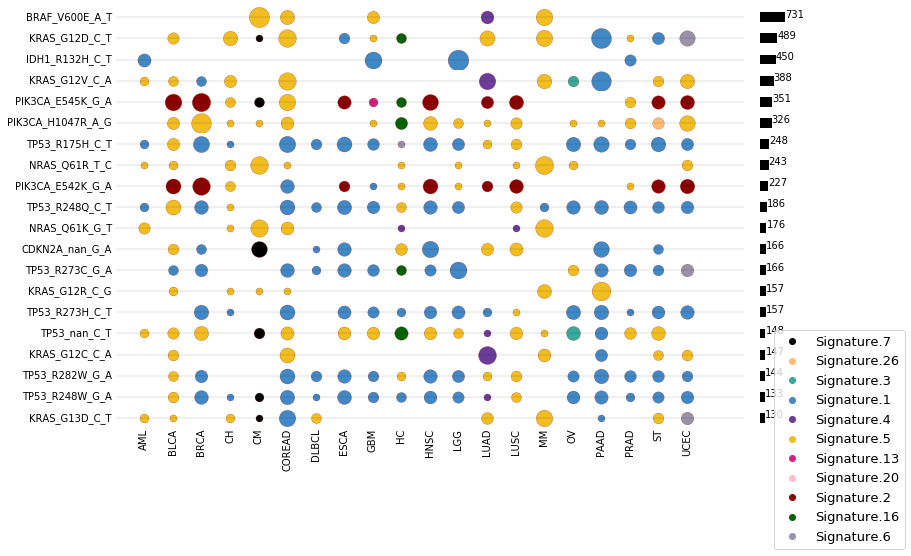

In [13]:
# subset
toplot4 = toplot_full.T[toplot_full.sum()>5].T
toplot4.columns = sorted(toplot4.columns)

fig,ax = plt.subplots()
fig.set_size_inches(12, 7.75)

toplot = toplot_full.head(n_mutations)
toplot4 = toplot.T[toplot.sum()>5].T
toplot4.columns = sorted(toplot4.columns)
gs = gridspec.GridSpec(figure=fig,ncols=2,nrows=n_mutations,width_ratios=[25,1])
gs.update(hspace=0.01,wspace=0.05)
axis = []


all_ttypes = toplot4.columns

# update axis with number of mutations
for i in range(0,(n_mutations)*2):
    axis.append(plt.subplot(gs[i]))

all_sigs = set()
for i in range(0,len(axis),2):

    ax = axis[i]

    # Plot scatter
    x_pos =  np.arange(len(toplot4.T))
    y_pos = np.zeros(len(toplot4.T))

    gene_index = i // 2
    
    mut_specific = toplot4.index.tolist()[gene_index]

    values = [50*np.log2(dic_sum_samples_ttype[mut_specific].get(ttype, 0)) for ttype in toplot4.columns]

    list_colors = [dictionary_colors[dic_sigs[mut_specific][col]] if col in dic_sigs[mut_specific] else 'white' for col in toplot4.columns ]
    
    list_sigs_final = set([dic_sigs[mut_specific][col] for col in toplot4.columns  if col in dic_sigs[mut_specific]  ])
    for sigl in list_sigs_final:
        all_sigs.add(sigl)
    
    ax.set_ylabel(mut_specific,fontsize=10,rotation=0,verticalalignment="center",horizontalalignment='right')

    ax.axhline(y=0,xmin=0.00,xmax=1,color='black',lw=0.25,alpha=0.5)
    
    for ix, expo in enumerate(toplot4.iloc[gene_index].tolist()):
        ax.scatter(x_pos[ix],y_pos[ix],s=values[ix],
                   color=list_colors[ix],linewidths=0.2,
                   edgecolors='darkred')

    ax.set_axisbelow(False)
    ax.set_yticks([])
    ax.set_xlim(-1,len(all_ttypes)+1)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Bar plot
maxv = np.nanmax(list(dic_sum_samples.values()))

for i in range(1,len(axis),2):
    ax = axis[i]
    
    # Plot bar
    gene_index = i // 2
    n_samples = dic_sum_samples[toplot4.index.tolist()[gene_index]]
    # Plot it
    ax.barh(i,n_samples,color='black',height=0.01,align='center')
    ax.annotate(xy=(n_samples+2,i),s=str(n_samples),fontsize=10, annotation_clip=False)
    ax.set_yticks([])
    ax.set_xticks([])
    ylims = ax.get_ylim()
    ax.set_ylim(ylims[0]-0.005,ylims[1]+0.005)
    ax.set_xlim(0,maxv)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

axis[-2].set_xticks([x for x in range(len(all_ttypes))])
_=axis[-2].set_xticklabels([x for x in all_ttypes],rotation=90,fontsize=3.25)        

axis[-2].tick_params(axis = 'x', labelsize =10  , pad=0.25,width=0.0, length = 0)
    
markers = [plt.Line2D([0,0],[0,0],color=dictionary_colors[sigc], marker='o', linestyle='') for sigc in all_sigs]
plt.legend(markers, all_sigs, numpoints=1, 
           bbox_to_anchor = [6,5], prop={'size': 13})

plt.show()

# Extended Figure 7c

In [14]:
def plot_mutations_heatmap_with_passenger_row(ttype, list_signatures, sorted_df, 
                                              color, colors_palette,  n_mutations=10):
        
    plt.rcParams['axes.axisbelow'] = True
    
    sum_all_exposures = np.sum(sorted_df['signatures2'].tolist(), axis = 0)
    
    forbidden_index = [ix for (ix , v) in enumerate(sum_all_exposures) if v == 0]
    
    list_signatures = [sig for (ix, sig) in enumerate(list_signatures) if ix not in forbidden_index]
    
    
    d_sigs = {sig : val for (sig, val) in zip(all_sigs, sum_all_exposures)}
    # create figure
    fig,ax = plt.subplots()
    fig.set_size_inches(7, 3.75)
    gs = gridspec.GridSpec(figure=fig,ncols=2,nrows=n_mutations,width_ratios=[15,1])
    gs.update(hspace=0.01,wspace=0.00)
    axis = []
    
    # update axis with number of mutations
    for i in range(0,(n_mutations)*2):
        axis.append(plt.subplot(gs[i]))

    for i in range(0,len(axis),2):
        
        ax = axis[i]
        
        # Plot scatter
        x_pos =  np.arange(len(list_signatures))
        y_pos = np.zeros(len(list_signatures))
        
        gene_index = i // 2
        mut = sorted_df.iloc[gene_index]['ID']

        values = [(v*7)**2 for (indx, v) in enumerate(sorted_df.iloc[gene_index]['signatures2'])
                  if indx not in forbidden_index]
                
        ax.set_ylabel(mut,fontsize=4.5,rotation=0,verticalalignment="center",horizontalalignment='right')
        
        ax.axhline(y=0,xmin=0.00,xmax=1,color=color,lw=0.25,alpha=0.5)
        
        ax.scatter(x_pos,y_pos,s=values,color=colors_palette,linewidths=0.2,edgecolors=colors_palette,alpha=1)
        ax.set_axisbelow(False)
        ax.set_yticks([])
        ax.set_xlim(-1,len(list_signatures)+1)
        ax.set_xticks([])
        ax.set_xlabel("")
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
 
        # Bar plot
    maxv = np.nanmax(sorted_df["sample_id"].values)
    values
    for i in range(1,len(axis)-2,2):
        ax = axis[i]
        # Plot bar
        gene_index = i // 2
        n_samples = sorted_df.iloc[gene_index]["sample_id"]
        # Plot it
        ax.barh(i,n_samples,color='black',height=0.01,align='center')
        ax.annotate(xy=(n_samples+2,i),s=str(n_samples),fontsize=3, annotation_clip=False)
        ax.set_yticks([])
        ax.set_xticks([])
        ylims = ax.get_ylim()
        ax.set_ylim(ylims[0]-0.005,ylims[1]+0.005)
        ax.set_xlim(0,maxv)
        ax.set_ylabel("")
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)


    axis[-2].set_xticks([x for x in range(len(list_signatures))])
    _=axis[-2].set_xticklabels([x for x in list_signatures],rotation=90,fontsize=6.25)        

    axis[-2].tick_params(axis = 'x', labelsize =4  , pad=0.25,width=0.0, length = 0)
    
    plt.show()


In [15]:
all_sigs = ['Signature.1', 'Signature.10',
       'Signature.11', 'Signature.12', 'Signature.13', 'Signature.14',
       'Signature.15', 'Signature.16', 'Signature.17', 'Signature.18',
       'Signature.2', 'Signature.20', 'Signature.21', 'Signature.22',
       'Signature.23', 'Signature.24', 'Signature.26', 'Signature.28',
       'Signature.3', 'Signature.30', 'Signature.4', 'Signature.5',
       'Signature.6', 'Signature.7', 'Signature.8', 'Signature.9']

signature_order = ['Signature.{}'.format(s) for s in np.arange(1, 31)]

signature_order_final = [s for s in signature_order if s not in ['Signature.19', 'Signature.29', 'Signature.27', 'Signature.25']]
dictionary_colors = {"Signature.1": "#9edae5", "Signature.2": "#ffbb78", "Signature.3": "#98df8a",
                     "Signature.4": "#e377c2", "Signature.5": "#D21F71", "Signature.6": "#ff7f0e",
                     "Signature.7": "#ff9896", "Signature.8": "#2ca02c", "Signature.9": "#d62728",
                     "Signature.10": "#B7D21F", "Signature.11": "#8c564b", "Signature.12": "#c7c7c7",
                     "Signature.13": "#1FD2CD", "Signature.14": "#1F32D2", "Signature.15": "#ff9896",
                     "Signature.16": "#C71FD2", "Signature.17": "#1f77b4", "Signature.18": "#6F3232",
                     "Signature.19": "#381144", "Signature.20": "#ffbb78", "Signature.21": "#bcbd22",
                     "Signature.22": "#8c564b", "Signature.23": "#1f77b4", "Signature.24": "#d62728", 
                     "Signature.25": "#9edae5", "Signature.26": "#c5b0d5", "Signature.27": "#2ca02c", 
                     "Signature.28": "#17becf", "Signature.29": "#f7b6d2", "Signature.30": "#c49c94"}

color_list = [dictionary_colors[s] for s in signature_order_final]


In [18]:
sorted_df = pd.read_csv("/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/blca.tsv", 
                       sep ="\t")

In [19]:
sorted_df["signatures2"] = sorted_df['signatures'].apply(lambda x : [float(i) for i in x[1:-1].split()])

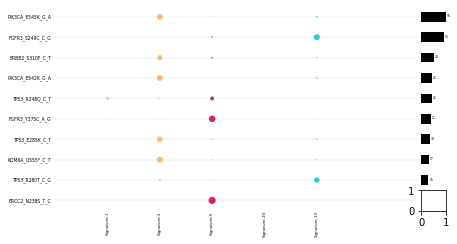

In [20]:
color_list = [dictionary_colors[s] for s in signature_order_final]
for ttype in ["BLCA"]:
    
    list_sigs = [float(s) for s in sorted_df[sorted_df['cancer_type']==ttype]['signatures'].tolist()[0][1:-1].split()]
    colors_palette = [color_list[ix] for ix, x in enumerate(list_sigs) if x >0]
    
    plot_mutations_heatmap_with_passenger_row(ttype, signature_order_final, 
                                              sorted_df[sorted_df['cancer_type']==ttype],
                                               'grey', colors_palette,  10,)


# Extended Figure 7d

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bgreference import hg38
from scipy.stats import mannwhitneyu
from glob import glob
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json


# config for matplotlib
def config_params(font_size=7):
    
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
def create_snv_class(df):

    pyr = ['C', 'T']
    rev = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    x=df['TRIPLET']
    
    if x[1] in pyr:
        out = '{}[{}>{}]{}'.format(x[0], x[1], df['alt'], x[2])
    else:
        out = '{}[{}>{}]{}'.format(rev[x[2]], rev[x[1]], rev[df['alt']], rev[x[0]])
    return out
    
def create_xticklabels(ax1, ax2, ax3, ax4, subset, ):
        

    ax1.set_xticks(np.arange(len(subset)))
    ax1.set_xticklabels(subset['alt'].tolist())

    # make every three of one color
    all_s = np.arange(len(subset))

    for i in all_s[::6]:
        for s in [0,1,2]:
            ax1.get_xticklabels()[i+s].set_color("red")


    ax1.set_xlim(0, len(subset))

    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    ax2.spines["bottom"].set_position(("axes", -0.15))

    ax2.set_xlim(0, len(subset))


    ax2.set_xticks([i for i in range(1, len(subset)+1, 3)])
    all_refs = subset['REF'].tolist()
    ax2.set_xticklabels([all_refs[i] for i in range(1, len(subset)+1, 3)])

    ax3.spines["bottom"].set_visible(True)
    ax3.set_ylim(-0.0001, 0.005)
    ax3.set_xlim(0, len(subset))

    # Move twinned axis ticks and label from top to bottom
    ax3.xaxis.set_ticks_position("bottom")
    ax3.xaxis.set_label_position("bottom")

    # Offset the twin axis below the host
    ax3.spines["bottom"].set_position(("axes", -0.30))
    ax3.spines["bottom"].set_visible(True)
    ax3.set_ylim(-0.0001, 0.005)

    # Offset the twin axis below the host
    ax3.set_xticks(np.arange(len(subset)))
    ax3.set_xticklabels(subset['AA_old'].tolist())

    # make every three of one color
    all_s = np.arange(len(subset))

    for i in all_s[::18]:
        for s in [0,1,2,3,4,5,6,7,8]:
            ax3.get_xticklabels()[i+s].set_color("darkblue")


    ax4.spines["bottom"].set_visible(True)
    ax4.set_ylim(-0.0001, 0.005)
    ax4.set_xlim(0, len(subset))

    # Move twinned axis ticks and label from top to bottom
    ax4.xaxis.set_ticks_position("bottom")
    ax4.xaxis.set_label_position("bottom")

    # Offset the twin axis below the host
    ax4.spines["bottom"].set_position(("axes", -0.4))
    ax4.spines["bottom"].set_visible(True)
    ax4.set_ylim(-0.0001, 0.005)

    ax4.set_xticks([i for i in range(4, len(subset), 9)])
    all_refs = subset['AA_new'].tolist()
    ax4.set_xticklabels([all_refs[i] for i in range(4, len(subset), 9)])

def plot_subset(subset_df, NAME,  positions_wanted, dic_color_sigs, dic_sigs, list_signatures = ['Signature.1', 
                                                                                       'Signature.2', 
                                                                                        'Signature.5']):

  
    fig = plt.figure(figsize = (10, 2))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax3 = ax1.twiny()
    ax4 = ax1.twiny()

    ax1.set_ylabel('Probability')
    
    subset_sigs = subset_df[list_signatures]
    subset_sigs = subset_sigs/subset_sigs.sum()
    bottom = np.array([0.0 for i in range(len(subset))])
    
    total = np.zeros(len(subset_df))
    for sig in list_signatures:
        vals = np.array([dic_sigs[sig][c] for c in subset_df['CLASS'].tolist()])
        total +=vals

    for sig in list_signatures:
        
        vals = np.array([dic_sigs[sig][c] for c in subset_df['CLASS'].tolist()])/total
            
        ax1.bar(np.arange(len(subset)), vals, 
                color = dic_color_sigs[sig], bottom = bottom)
        
        bottom += vals
    
        
    create_xticklabels(ax1, ax2, ax3, ax4, subset_df)
    ax1.set_ylim(0, 1)
    
    plt.show()
    
    fig = plt.figure(figsize = (10, 2))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    ax3 = ax1.twiny()
    ax4 = ax1.twiny()

    ax1.set_ylabel('MutRate')
    
    
    ax1.plot(subset_df['PROBABILITY'].tolist(), 
                color = 'darkred')
        
    
    ax1.set_xlim(0, len(subset_df))
    
    ax1.set_xlim(0, len(subset_df))
    
    plt.show()

def order_muts():

    order = []
    first = ['A', 'C', 'G', 'T']
    pyr = ['C', 'T']
    for p in pyr:
        for mut in first:
            if mut != p:
                for f in first:
                    for f2 in first:
                        comb = '{}[{}>{}]{}'.format(f, p, mut, f2)
                        order.append(comb)
    
    return order
    
config_params(7)

In [22]:
dic_color_sigs = {
        'Signature.5': '#F2BD1F',
        'Signature.15': '#b15928',
        'Signature.2': 'darkred',
        'Signature.4': '#6a3d9a',
        'Signature.9': '#cab2d6',
        'Signature.10': '#e31a1c',
        'Signature.18': '#c69f04',
        'Signature.26': '#fdbf6f',
        'Signature.17': '#33a02c',
        'Signature.7': 'black',
        'Signature.13': '#D32181',
        'Signature.28': '#b2df8a',
        'Signature.1': '#4188C6',
        'Signature.27': '#a6cee3',
        'Signature.16': 'darkgreen',
        'Signature.14': '#aa00ff',
        'Signature.3': '#38aa9d',
        'Signature.6': '#9992aa',
        'Signature.12': '#aaa1a1',
        'Signature.30': '#7d3a3b',
        'Signature.11': 'green',
        'Signature.19': 'grey',
        'Signature.20': 'pink',
        'Signature.21': 'blue',
        'Signature.22': 'white',
        'Signature.23': 'darkblue',
        'Signature.24': 'orange',
        'Signature.25': 'darkorange',
        'Signature.29': 'grey',
        'Signature.8': '#E3A663'
    }

In [23]:
signatures_file = '/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/SigProfiler_COSMIC.deconstructsigs.tsv'
df_sigs = pd.read_csv(signatures_file, sep ='\t')
dic_sigs = df_sigs.to_dict(orient='index')

/home/opich/miniconda3/envs/healthy/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


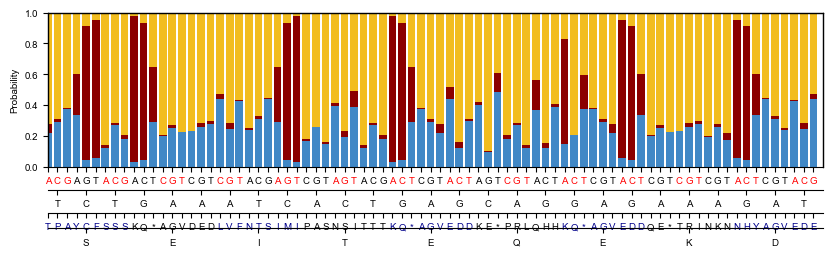

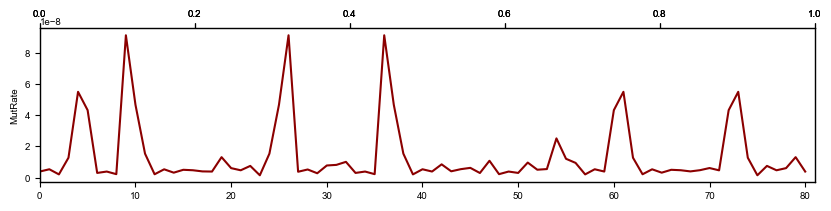

In [24]:

df = pd.read_csv('/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/PIK3CA.BRCA.prediction.out.signatures.gz', 
                sep ='\t')

config_params(7)

signature_columns = [x for x in df.columns if 'Signature' in x]
df['REF'] = df['TRIPLET'].apply(lambda x :x[1])
df['AA_new'] = df['aachange'].apply(lambda x : x[0])
df['AA_old'] = df['aachange'].apply(lambda x : x[-1])
df['Protein_position'] = df['aachange'].apply(lambda x : int(x[1:-1]))

mutrate = '/workspace/projects/boostdm/nature-release/source-data/extended-figure7-source-data/norm_PIK3CA.out.json'

dic_mutrate = json.load(open(mutrate, 'rt'))
toappend = []
for sample, v in dic_mutrate['PIK3CA'].items():
    toappend.append(v)
    
mean_context = np.mean(toappend, axis = 0)

order_snvs = order_muts()
dic_probability = {o:mean_context[ix] for ix, o in enumerate(order_snvs)}
subset=df[(df['Protein_position']>540)&(df['Protein_position']<550)]
subset['PROBABILITY'] = subset['CLASS'].map(dic_probability)

# plot
plot_subset(subset, "PIK3CA", [9, 36],  dic_color_sigs, dic_sigs,)